# Modeling

## Load Data

In [1]:
fh = 24 # forecast horizon, predice el consumo dentro de fh horas

import pandas as pd
import numpy as np
from pathlib import Path
import sys
import joblib
sys.path.append('../src')

from modeling.baseline import LagNaive, RollingMeanNaive #, MovingAverageNaive
from modeling.traditional_ml import train_random_forest, train_xgboost, train_lightgbm, plot_learning_curve
from utils.metrics import calculate_metrics, print_metrics
results = []

# Cargar splits
data_dir = Path('../data/processed')

train_df = pd.read_csv(data_dir / f'train_{fh}hr.csv', index_col='Datetime', parse_dates=True)
val_df = pd.read_csv(data_dir / f'val_{fh}hr.csv', index_col='Datetime', parse_dates=True)
test_df = pd.read_csv(data_dir / f'test_{fh}hr.csv', index_col='Datetime', parse_dates=True)

# Separar X e y
TARGET_COL = 'PJME_MW'
feature_cols = [col for col in train_df.columns if col != TARGET_COL]

X_train, y_train = train_df[feature_cols], train_df[TARGET_COL]
X_val, y_val = val_df[feature_cols], val_df[TARGET_COL]
X_test, y_test = test_df[feature_cols], test_df[TARGET_COL]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}\n")

train_df.info()
# train_df.describe()
# train_df['PJME_MW'].describe()

X_train shape: (97548, 49)
X_val shape: (20879, 49)
X_test shape: (20880, 49)

<class 'pandas.DataFrame'>
DatetimeIndex: 97548 entries, 2002-01-09 02:00:00 to 2013-09-06 13:00:00
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PJME_MW                 97548 non-null  float64
 1   hour                    97548 non-null  int64  
 2   dayofweek               97548 non-null  int64  
 3   quarter                 97548 non-null  int64  
 4   month                   97548 non-null  int64  
 5   year                    97548 non-null  int64  
 6   dayofyear               97548 non-null  int64  
 7   weekofyear              97548 non-null  int64  
 8   is_weekend              97548 non-null  int64  
 9   is_month_start          97548 non-null  int64  
 10  is_month_end            97548 non-null  int64  
 11  hour_sin                97548 non-null  float64
 12  hour_cos                97548 non-null  f

## Baseline Models

In [2]:
if fh == 1:
    # Lag Naive last hour
    print('Model: Lag Naive 1 hr') #valor de hace 1 hora
    lag_naive = LagNaive(lag_column='lag_1')
    lag_naive.fit(X_train, y_train)
    val_pred = lag_naive.predict(X_val)
    metrics = calculate_metrics(y_val, val_pred, 'LagNaive_1hr - Validation')
    print_metrics(metrics)
    results.append({'model': 'Lag_Naive_1hr', **metrics})

# Lag Naive last day
print('Model: Lag Naive 1 day') #valor de hace 1 día
lag_naive = LagNaive(lag_column='lag_24')
lag_naive.fit(X_train, y_train)
val_pred = lag_naive.predict(X_val)
metrics = calculate_metrics(y_val, val_pred, 'LagNaive_1day - Validation')
print_metrics(metrics)
results.append({'model': 'Lag_Naive_1day', **metrics})

# Lag Naive last week
print('Model: Lag Naive 1 week') #valor de hace 1 semana
lag_naive = LagNaive(lag_column='lag_168')
lag_naive.fit(X_train, y_train)
val_pred = lag_naive.predict(X_val)
metrics = calculate_metrics(y_val, val_pred, 'LagNaive_1week - Validation')
print_metrics(metrics)
results.append({'model': 'Lag_Naive_1week', **metrics})


# Rolling Mean 24h
print("\nModel: Rolling Mean 24h")
rm24 = RollingMeanNaive("rolling_mean_24")
rm24.fit(X_train, y_train)

val_pred_24 = rm24.predict(X_val)
metrics_24 = calculate_metrics(y_val, val_pred_24, "RollingMean_24 - Validation")
print_metrics(metrics_24)

results.append({'model': 'RollingMean_24', **metrics_24})

# Rolling Mean 168h
print("\nModel: Rolling Mean 168h")
rm168 = RollingMeanNaive("rolling_mean_168")
rm168.fit(X_train, y_train)

val_pred_168 = rm168.predict(X_val)
metrics_168 = calculate_metrics(y_val, val_pred_168, "RollingMean_168 - Validation")
print_metrics(metrics_168)

results.append({'model': 'RollingMean_168', **metrics_168})

Model: Lag Naive 1 day

Métricas - LagNaive_1day - Validation
Mean_True:  31,543.85 MW
Std_True: 6,206.20 MW
MAE:  3,411.40 MW
RMSE: 4,469.49 MW
MAPE: 10.71%
R²:   0.4814

Model: Lag Naive 1 week

Métricas - LagNaive_1week - Validation
Mean_True:  31,543.85 MW
Std_True: 6,206.20 MW
MAE:  3,560.97 MW
RMSE: 4,713.38 MW
MAPE: 11.04%
R²:   0.4232


Model: Rolling Mean 24h

Métricas - RollingMean_24 - Validation
Mean_True:  31,543.85 MW
Std_True: 6,206.20 MW
MAE:  4,223.53 MW
RMSE: 5,357.66 MW
MAPE: 13.81%
R²:   0.2548


Model: Rolling Mean 168h

Métricas - RollingMean_168 - Validation
Mean_True:  31,543.85 MW
Std_True: 6,206.20 MW
MAE:  4,220.82 MW
RMSE: 5,341.26 MW
MAPE: 13.82%
R²:   0.2593



## Traditional ML Models

### Create Models

In [3]:
# # Random Forest
# print('\n Model: Random Forest')
# rf, rf_train_pred , rf_val_pred = train_random_forest(
#     X_train, y_train, X_val, y_val,
#     save_path=f'../models/random_forest_{fh}hr.pkl'
# )
# metrics_rf = calculate_metrics(y_val, rf_val_pred, 'Random Forest - Validation')
# print_metrics(metrics_rf)
# results.append({'model': 'Random_Forest', **metrics_rf})

# # XGBoost
# print('\n Model: XGBoost')
# xgb, xgb_train_pred, xgb_val_pred = train_xgboost(
#     X_train, y_train, X_val, y_val,
#     save_path=f'../models/xgboost_{fh}hr.pkl'
# )

# metrics_xgb = calculate_metrics(y_val, xgb_val_pred, 'XGBoost - Validation')
# print_metrics(metrics_xgb)
# results.append({'model': 'XGBoost', **metrics_xgb})
# plot_learning_curve(xgb, model_name='XGBoost')

# # LightGBM
# print('\n Model: LightGBM')
# lgbm, lgbm_train_pred, lgbm_val_pred = train_lightgbm(
#     X_train, y_train, X_val, y_val,
#     save_path=f'../models/lightgbm_{fh}hr.pkl'
# )
# metrics_lgbm = calculate_metrics(y_val, lgbm_val_pred, "LightGBM - Validation")
# print_metrics(metrics_lgbm)
# results.append({'model': 'LightGBM', **metrics_lgbm})
# plot_learning_curve(lgbm, model_name='LightGBM')

### Load Models


CARGANDO MODELOS OPTIMIZADOS (de Optuna)

Cargando XGBoost optimizado...

Métricas - XGBoost Optimizado - Validation
Mean_True:  31,543.85 MW
Std_True: 6,206.20 MW
MAE:  1,997.95 MW
RMSE: 2,657.86 MW
MAPE: 6.26%
R²:   0.8166


Cargando LightGBM optimizado...

Métricas - LightGBM Optimizado - Validation
Mean_True:  31,543.85 MW
Std_True: 6,206.20 MW
MAE:  2,065.94 MW
RMSE: 2,727.31 MW
MAPE: 6.50%
R²:   0.8069


Random Forest...
   Cargando Random Forest existente...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished



Métricas - Random Forest - Validation
Mean_True:  31,543.85 MW
Std_True: 6,206.20 MW
MAE:  2,119.15 MW
RMSE: 2,855.02 MW
MAPE: 6.62%
R²:   0.7884


GENERANDO VISUALIZACIONES
Learning curve guardada: ..\reports\figures\learning_curve_XGBoost.png


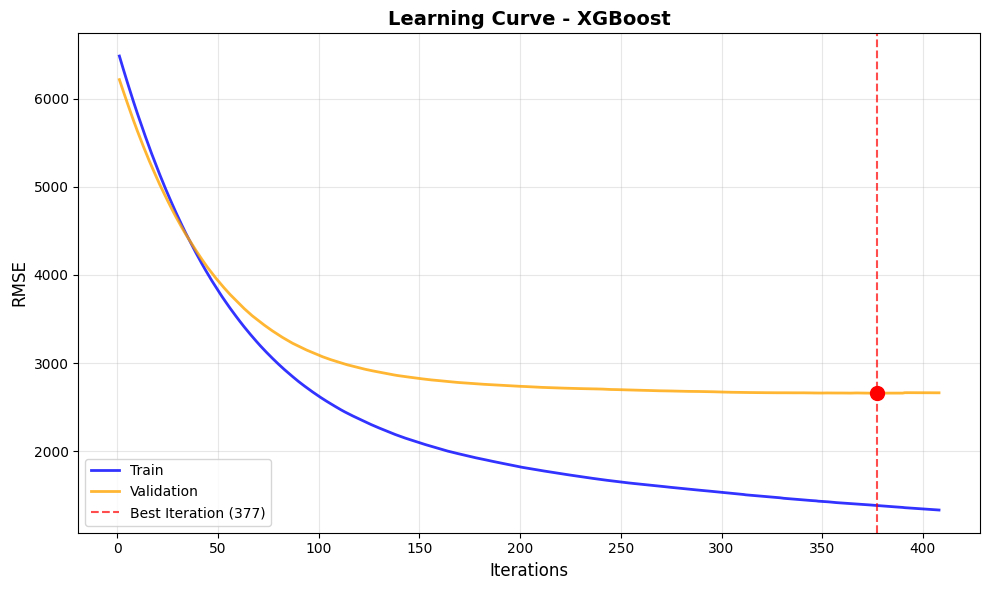

Learning curve guardada: ..\reports\figures\learning_curve_LightGBM.png


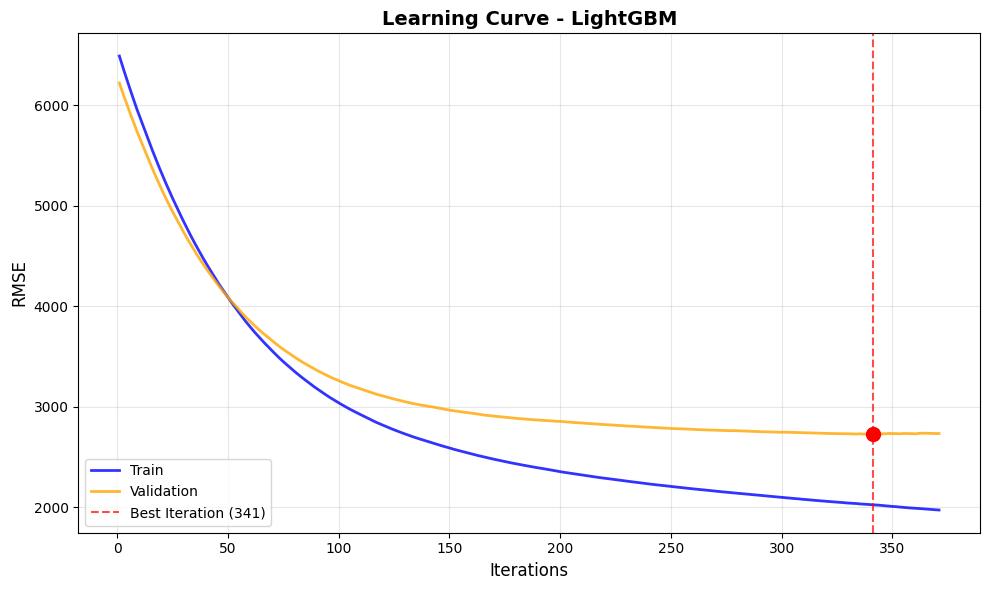

In [4]:
# ==========================================
# Entrenar modelos nuevos o cargar optimizados
# ==========================================
USE_OPTIMIZED_MODELS = True  # ← Cambia a False para entrenar desde cero

models_dir = Path('../models')
from xgboost import XGBRegressor
import lightgbm as lgbm

if USE_OPTIMIZED_MODELS:
    print("\n" + "="*70)
    print("CARGANDO MODELOS OPTIMIZADOS (de Optuna)")
    print("="*70)
    
    # Verificar que existen los modelos optimizados
    xgb_path = models_dir / f'xgboost_optimized_{fh}hr.pkl'
    lgbm_path = models_dir / f'lightgbm_optimized_{fh}hr.pkl'
    rf_path = models_dir / f'random_forest_{fh}hr.pkl'  # RF no fue optimizado
    
    if not xgb_path.exists() or not lgbm_path.exists():
        print("Modelos optimizados no encontrados. Ejecuta el notebook de Optuna primero.")
        print("   Cambiando a entrenamiento desde cero...")
        USE_OPTIMIZED_MODELS = False
    else:
        # Cargar XGBoost optimizado
        print('\nCargando XGBoost optimizado...')
        xgb = joblib.load(xgb_path)
        xgb_val_pred = xgb.predict(X_val)
        
        metrics_xgb = calculate_metrics(y_val, xgb_val_pred, 'XGBoost Optimizado - Validation')
        print_metrics(metrics_xgb)
        results.append({'model': 'XGBoost_Optimized', **metrics_xgb})
        
        # Cargar LightGBM optimizado
        print('\nCargando LightGBM optimizado...')
        lgbm_m = joblib.load(lgbm_path)
        lgbm_val_pred = lgbm_m.predict(X_val)
        
        metrics_lgbm = calculate_metrics(y_val, lgbm_val_pred, 'LightGBM Optimizado - Validation')
        print_metrics(metrics_lgbm)
        results.append({'model': 'LightGBM_Optimized', **metrics_lgbm})
        
        # Random Forest (entrenar o cargar si existe)
        print('\nRandom Forest...')
        if rf_path.exists():
            print("   Cargando Random Forest existente...")
            rf = joblib.load(rf_path)
            rf_train_pred = rf.predict(X_train)
            rf_val_pred = rf.predict(X_val)
        else:
            print("   Entrenando Random Forest...")
            rf, rf_train_pred, rf_val_pred = train_random_forest(
                X_train, y_train, X_val, y_val,
                save_path=rf_path
            )
        
        metrics_rf = calculate_metrics(y_val, rf_val_pred, 'Random Forest - Validation')
        print_metrics(metrics_rf)
        results.append({'model': 'Random_Forest', **metrics_rf})

if not USE_OPTIMIZED_MODELS:
    print("\n" + "="*70)
    print("ENTRENANDO MODELOS DESDE CERO")
    print("="*70)
    
    # Random Forest
    print('\nModel: Random Forest')
    rf, rf_train_pred, rf_val_pred = train_random_forest(
        X_train, y_train, X_val, y_val,
        save_path=models_dir / f'random_forest_{fh}hr.pkl'
    )
    metrics_rf = calculate_metrics(y_val, rf_val_pred, 'Random Forest - Validation')
    print_metrics(metrics_rf)
    results.append({'model': 'Random_Forest', **metrics_rf})
    
    import json

    # ==========================================
    # CARGAR PARÁMETROS DESDE JSON
    # ==========================================

    with open(models_dir / f'optuna_results_{fh}hr.json', 'r') as f:
        optuna_results = json.load(f)

    # ==========================================
    # XGBOOST
    # ==========================================
    print("\n" + "="*70)
    print("XGBOOST OPTIMIZADO")
    print("="*70)

    xgb_params = {
        **optuna_results['xgboost']['best_params'],
        'n_estimators': 500,
        'early_stopping_rounds': 30,
        'eval_metric': 'rmse',
        'random_state': 22,
        'n_jobs': -1
    }

    xgb = XGBRegressor(**xgb_params)
    xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=100)
    print(f"Paró en iteración: {xgb.best_iteration}/500\n")

    xgb_val_pred = xgb.predict(X_val)
    
    metrics_xgb = calculate_metrics(y_val, xgb_val_pred, 'XGBoost - Validation')
    print_metrics(metrics_xgb)
    results.append({'model': 'XGBoost', **metrics_xgb})


    # ==========================================
    # LIGHTGBM
    # ==========================================
    print("="*70)
    print("LIGHTGBM OPTIMIZADO")
    print("="*70)

    lgbm_params = {
        **optuna_results['lightgbm']['best_params'],
        'n_estimators': 500,
        'random_state': 22,
        'n_jobs': -1,
        'verbosity': 1
    }

    lgbm_m = lgbm.LGBMRegressor(**lgbm_params)
    lgbm_m.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        callbacks=[lgbm.early_stopping(30), lgbm.log_evaluation(60)]
    )
    print(f"Paró en iteración: {lgbm_m.best_iteration_}/500\n")
        

    lgbm_val_pred = lgbm_m.predict(X_val)
    
    metrics_lgbm = calculate_metrics(y_val, lgbm_val_pred, 'LightGBM Optimizado - Validation')
    print_metrics(metrics_lgbm)
    results.append({'model': 'LightGBM', **metrics_lgbm})

    # ==========================================
    # GUARDAR
    # ==========================================
    joblib.dump(xgb, models_dir / f'xgboost_optimized_{fh}hr.pkl')
    joblib.dump(lgbm_m, models_dir / f'lightgbm_optimized_{fh}hr.pkl')
    print("Modelos guardados")


# ==========================================
# VISUALIZACIONES (funciona con ambas opciones)
# ==========================================
print("\n" + "="*70)
print("GENERANDO VISUALIZACIONES")
print("="*70)

plot_learning_curve(xgb, model_name='XGBoost')
plot_learning_curve(lgbm_m, model_name='LightGBM')

In [5]:
# =====================
# Model Comparison
# =====================

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')
print("\n" + "="*70)
print(" Ranking de Modelos (ordenado por RMSE)")
print("="*70)
print(results_df[['model', 'Mean_True', 'Std_True', 'MAE', 'RMSE', 'MAPE', 'R2']].to_string(index=False))

# Guardar resultados
results_df.to_csv(f'../results/model_comparison_{fh}hr.csv', index=False)
print(f"\n Resultados guardados en: ../results/model_comparison_{fh}hr.csv")


 Ranking de Modelos (ordenado por RMSE)
             model    Mean_True    Std_True         MAE        RMSE      MAPE       R2
 XGBoost_Optimized 31543.852531 6206.201874 1997.953850 2657.856693  6.263510 0.816595
LightGBM_Optimized 31543.852531 6206.201874 2065.944233 2727.306881  6.504695 0.806885
     Random_Forest 31543.852531 6206.201874 2119.153975 2855.021093  6.620872 0.788375
    Lag_Naive_1day 31543.852531 6206.201874 3411.401121 4469.488118 10.706419 0.481363
   Lag_Naive_1week 31543.852531 6206.201874 3560.971790 4713.382833 11.042047 0.423215
   RollingMean_168 31543.852531 6206.201874 4220.815288 5341.259961 13.816628 0.259311
    RollingMean_24 31543.852531 6206.201874 4223.525408 5357.663979 13.807852 0.254755

 Resultados guardados en: ../results/model_comparison_24hr.csv


In [6]:
xgb_test_pred = xgb.predict(X_test)
metrics_xgb_test = calculate_metrics(y_test, xgb_test_pred, 'XGBoost - Test')
print_metrics(metrics_xgb_test)

lgbm_test_pred = lgbm_m.predict(X_test)
metrics_lgbm_test = calculate_metrics(y_test, lgbm_test_pred, 'lgbm - Test')
print_metrics(metrics_lgbm_test)


Métricas - XGBoost - Test
Mean_True:  31,054.16 MW
Std_True: 6,509.82 MW
MAE:  2,290.54 MW
RMSE: 3,014.25 MW
MAPE: 7.35%
R²:   0.7856




Métricas - lgbm - Test
Mean_True:  31,054.16 MW
Std_True: 6,509.82 MW
MAE:  2,324.65 MW
RMSE: 3,026.76 MW
MAPE: 7.49%
R²:   0.7838



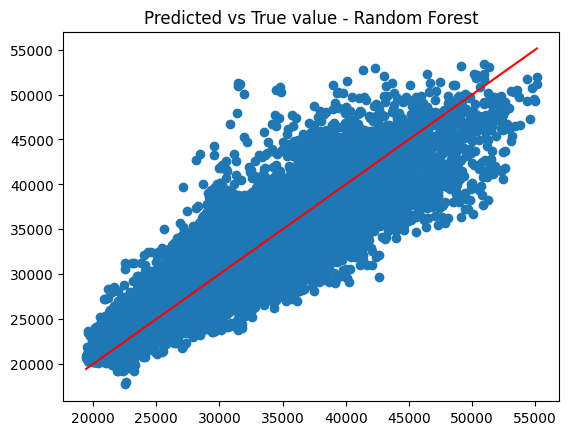

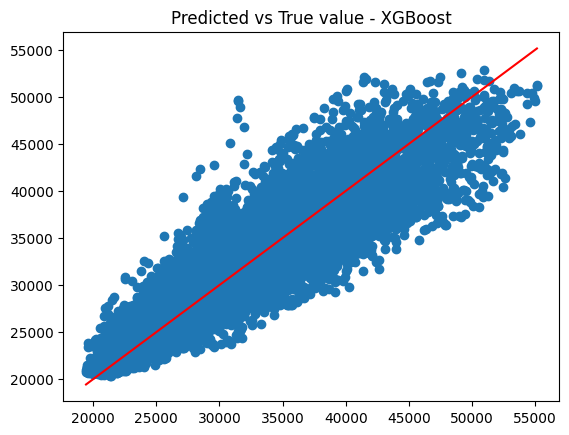

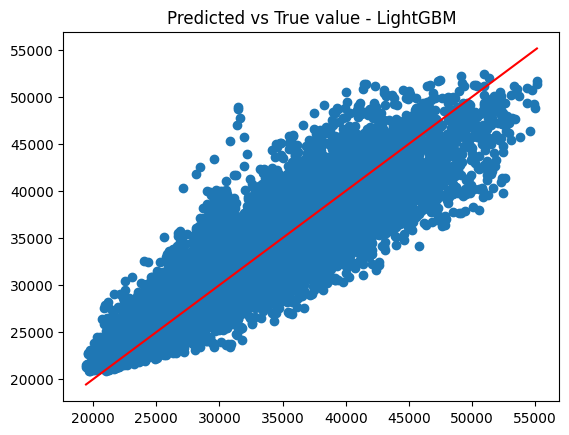

In [7]:
import matplotlib.pyplot as plt
plt.scatter(y_val, rf_val_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r')
plt.title('Predicted vs True value - Random Forest')
plt.show()

plt.scatter(y_val, xgb_val_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r')
plt.title('Predicted vs True value - XGBoost')
plt.show()

plt.scatter(y_val, lgbm_val_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r')
plt.title('Predicted vs True value - LightGBM')
plt.show()

In [8]:
# Feature importance de Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15))

# ¿lag_1 domina todo?
if fh==1:
    lag1_importance = feature_importance[feature_importance['feature'] == 'lag_1']['importance'].values[0]
    print(f"\nImportancia de lag_1: {lag1_importance:.1%}")
    print(f"Importancia del resto: {1-lag1_importance:.1%}")


                  feature  importance
18                 lag_24    0.521332
23                lag_168    0.117927
15          dayofweek_cos    0.052964
0                    hour    0.036009
28         rolling_max_24    0.033833
21                 lag_47    0.018851
1               dayofweek    0.017931
14          dayofweek_sin    0.015429
41    volatility_range_24    0.014414
27         rolling_min_24    0.012675
19                 lag_25    0.011637
5               dayofyear    0.010917
46      volatility_iqr_24    0.008990
44  volatility_changes_24    0.008847
48         expanding_mean    0.008231


In [9]:
# # XGBoost - tres tipos disponibles
# xgb.get_booster().get_score(importance_type='weight')   # frecuencia (default)
# xgb.get_booster().get_score(importance_type='gain')     # reducción promedio de impureza ← más informativo
# xgb.get_booster().get_score(importance_type='cover')    # cantidad de muestras afectadas

# # LightGBM - dos tipos disponibles
# lgbm.booster_.feature_importance(importance_type='split')  # frecuencia (default)
# lgbm.booster_.feature_importance(importance_type='gain')   # reducción de impureza ← más informativo

In [10]:
metric_type = 'gain'  # opciones: 'gain', 'weight', 'cover'

# Feature importance - XGBoost
xgb_gain_scores = xgb.get_booster().get_score(importance_type=metric_type)
feature_importance_xgb_gain = pd.DataFrame({
    'feature': list(xgb_gain_scores.keys()),
    metric_type: list(xgb_gain_scores.values())
}).sort_values(metric_type, ascending=False).reset_index(drop=True)

feature_importance_xgb_gain[f'{metric_type}_pct'] = (
    feature_importance_xgb_gain[metric_type] / feature_importance_xgb_gain[metric_type].sum() * 100
).round(2)

print("="*50)
print(f"XGBoost - Feature Importance ({metric_type})")
print("="*50)
print(feature_importance_xgb_gain.head(15).to_string(index=True))


XGBoost - Feature Importance (gain)
                feature          gain  gain_pct
0                lag_24  9.611778e+09     31.96
1               lag_168  5.151444e+09     17.13
2         dayofweek_cos  2.091941e+09      6.96
3                lag_25  1.935567e+09      6.44
4                  hour  1.160522e+09      3.86
5        rolling_max_24  8.892761e+08      2.96
6             dayofweek  7.583972e+08      2.52
7                lag_48  7.315976e+08      2.43
8         dayofweek_sin  5.585822e+08      1.86
9              hour_sin  5.510022e+08      1.83
10  volatility_range_24  4.075305e+08      1.36
11             hour_cos  4.052402e+08      1.35
12               lag_47  3.511785e+08      1.17
13              lag_169  3.323098e+08      1.10
14            month_cos  3.255226e+08      1.08


In [11]:

metric_type = 'gain'  # opciones: 'gain', 'split'
# Feature importance - LightGBM
feature_importance_lgbm_gain = pd.DataFrame({
    'feature': X_train.columns,
    metric_type: lgbm_m.booster_.feature_importance(importance_type=metric_type)
}).sort_values(metric_type, ascending=False).reset_index(drop=True)

feature_importance_lgbm_gain[f'{metric_type}_pct'] = (
    feature_importance_lgbm_gain[metric_type] / feature_importance_lgbm_gain[metric_type].sum() * 100
).round(2)

print("\n" + "="*50)
print(f"LightGBM - Feature Importance ({metric_type})")
print("="*50)
print(feature_importance_lgbm_gain.head(15).to_string(index=True))


LightGBM - Feature Importance (gain)
                feature          gain  gain_pct
0                lag_24  5.181687e+13     38.83
1               lag_168  1.884652e+13     14.12
2                  hour  9.725243e+12      7.29
3                lag_25  6.465899e+12      4.84
4        rolling_max_24  6.250302e+12      4.68
5         dayofweek_cos  5.732961e+12      4.30
6             dayofweek  4.199126e+12      3.15
7                lag_48  2.691546e+12      2.02
8               lag_169  2.602591e+12      1.95
9         dayofweek_sin  2.073132e+12      1.55
10       rolling_min_24  2.025378e+12      1.52
11  volatility_range_24  1.942812e+12      1.46
12            dayofyear  1.668812e+12      1.25
13             hour_sin  1.552372e+12      1.16
14      rolling_max_168  1.255533e+12      0.94


In [12]:
comparison = pd.DataFrame({
    'feature': feature_importance_xgb_gain['feature'],
    'xgb_gain_pct': feature_importance_xgb_gain['gain_pct']
}).merge(
    feature_importance_lgbm_gain[['feature', 'gain_pct']].rename(columns={'gain_pct': 'lgbm_gain_pct'}),
    on='feature', how='outer'
).merge(
    feature_importance[['feature', 'importance']].rename(columns={'importance': 'rf_importance'}),
    on='feature', how='outer'
).fillna(0).sort_values('xgb_gain_pct', ascending=False).reset_index(drop=True)

print("\n" + "="*65)
print("Comparación Feature Importance - XGB vs LGBM vs RF")
print("="*65)
print(comparison.to_string(index=True))


Comparación Feature Importance - XGB vs LGBM vs RF
                   feature  xgb_gain_pct  lgbm_gain_pct  rf_importance
0                   lag_24         31.96          38.83       0.521332
1                  lag_168         17.13          14.12       0.117927
2            dayofweek_cos          6.96           4.30       0.052964
3                   lag_25          6.44           4.84       0.011637
4                     hour          3.86           7.29       0.036009
5           rolling_max_24          2.96           4.68       0.033833
6                dayofweek          2.52           3.15       0.017931
7                   lag_48          2.43           2.02       0.003833
8            dayofweek_sin          1.86           1.55       0.015429
9                 hour_sin          1.83           1.16       0.007737
10     volatility_range_24          1.36           1.46       0.014414
11                hour_cos          1.35           0.89       0.003860
12                  lag_4